# YOLOv5 FSOCO Training

**Essential steps only:**
1. Setup YOLOv5
2. Convert FSOCO labels (Supervisely → YOLO)
3. Train
4. Inference

**Run from:** `driverless-ml-dev/perceptions/camera-pipeline/notebooks/`

**Activate venv in root/driverless-ml-dev directory, and connect kernel for this notebook to it**

## 1. Setup

In [64]:
import os
import sys
from pathlib import Path

# Paths
ROOT = Path.cwd().parent.parent.parent  # driverless-ml-dev/
print(ROOT)
YOLO_DIR = ROOT / 'yolov5'
DATA_DIR = ROOT / 'ml_data'
FSOCO_RAW = ROOT / 'ml_data/perceptions/fsoco_sample'  # Download FSOCO here
FSOCO_YOLO = ROOT / 'ml_data/perceptions/fsoco_yolo'  # Converted dataset

print(f"Root: {ROOT}")
print(f"YOLOv5: {YOLO_DIR}")
print(f"Data: {DATA_DIR}")
print(f"Fsoco_raw: {FSOCO_RAW}")
print(f"Fsoco_raw: {FSOCO_YOLO}")

/root/driverless-ml-dev
Root: /root/driverless-ml-dev
YOLOv5: /root/driverless-ml-dev/yolov5
Data: /root/driverless-ml-dev/ml_data
Fsoco_raw: /root/driverless-ml-dev/ml_data/perceptions/fsoco_sample
Fsoco_raw: /root/driverless-ml-dev/ml_data/perceptions/fsoco_yolo


In [65]:
# Clone YOLOv5
if not YOLO_DIR.exists():
    !cd {ROOT} && git clone https://github.com/ultralytics/yolov5.git
    print("✓ YOLOv5 cloned")
else:
    print("✓ YOLOv5 exists")

# Install requirements
%pip install -q -r {YOLO_DIR}/requirements.txt
print("✓ Dependencies installed")

✓ YOLOv5 exists
Note: you may need to restart the kernel to use updated packages.
✓ Dependencies installed


## 2. Download FSOCO Dataset

**Manual step required:**
1. Visit: https://www.fsoco-dataset.com/download
2. Download dataset (Supervisely format)
3. Extract to: `data/fsoco_raw/`

Expected structure:
```
data/fsoco_raw/
└── dataset_name/
    ├── ann/       # JSON annotations
    ├── img/       # Images
    └── meta.json
```

In [66]:
# Check dataset
if FSOCO_RAW.exists() and any(FSOCO_RAW.iterdir()):
    print("✓ FSOCO dataset found")
    for item in FSOCO_RAW.iterdir():
        print(f"  - {item.name}")
else:
    print("✗ Download FSOCO dataset to:", FSOCO_RAW)
    FSOCO_RAW.mkdir(parents=True, exist_ok=True)

✓ FSOCO dataset found
  - bounding_boxes
  - labels.cache
  - classes.txt
  - .DS_Store
  - images
  - segmentation
  - labels
  - gt_viz
  - meta.json


In [67]:
# Check structure
print("bounding_boxes contents:")
bb_path = FSOCO_RAW / 'bounding_boxes'
if bb_path.exists():
    for item in list(bb_path.iterdir())[:5]:
        print(f"  {item.name}")

print("\nimages contents:")
img_path = FSOCO_RAW / 'images'
if img_path.exists():
    for item in list(img_path.iterdir())[:5]:
        print(f"  {item.name}")

print("\nmeta.json:")
meta_path = FSOCO_RAW / 'meta.json'
if meta_path.exists():
    import json
    meta = json.load(open(meta_path))
    print(json.dumps(meta, indent=2)[:500])

bounding_boxes contents:
  amz_00588.jpg.json
  mms_00610.jpg.json
  amz_00016.jpg.json
  mms_00597.jpg.json
  ff_00006.png.json

images contents:
  mms_00614.jpg
  amz_00736.png
  mms_00610.jpg
  mms_00597.jpg
  ff_00267.png

meta.json:
{
  "classes": [
    {
      "title": "seg_blue_cone",
      "shape": "bitmap",
      "color": "#2A00FF"
    },
    {
      "title": "seg_unknown_cone",
      "shape": "bitmap",
      "color": "#3BDB0F"
    },
    {
      "title": "seg_yellow_cone",
      "shape": "bitmap",
      "color": "#FFFF00"
    },
    {
      "title": "blue_cone",
      "shape": "rectangle",
      "color": "#2A00FF"
    },
    {
      "title": "orange_cone",
      "shape": "rectangle",
      "color": "#FF8000"
    },
   


## 3. Convert Labels: Supervisely → YOLO

YOLO format: `<class_id> <x_center> <y_center> <width> <height>` (all normalized 0-1)

In [68]:
import json
import shutil
from PIL import Image
from tqdm import tqdm
import random

# Add code for conversion

def convert_supervisely_to_yolo(fsoco_raw, fsoco_yolo, split=(0.8, 0.1, 0.1)):
    """Convert FSOCO Supervisely format to YOLO format."""
    
    # Create directories
    for s in ['train', 'val', 'test']:
        (fsoco_yolo / 'images' / s).mkdir(parents=True, exist_ok=True)
        (fsoco_yolo / 'labels' / s).mkdir(parents=True, exist_ok=True)
    
    # Load class names from meta.json (only rectangle classes for bounding boxes)
    meta = json.load(open(fsoco_raw / 'meta.json'))
    classes = [c['title'] for c in meta['classes'] if c['shape'] == 'rectangle']
    class_map = {name: i for i, name in enumerate(classes)}
    print(f"Classes (bounding boxes only): {classes}\n")
    
    # Get all annotation files
    ann_dir = fsoco_raw / 'bounding_boxes'
    img_dir = fsoco_raw / 'images'
    
    ann_files = list(ann_dir.glob('*.json'))
    print(f"Total annotations: {len(ann_files)}")
    
    # Split dataset
    random.shuffle(ann_files)
    n1 = int(len(ann_files) * split[0])
    n2 = int(len(ann_files) * (split[0] + split[1]))
    splits = {
        'train': ann_files[:n1],
        'val': ann_files[n1:n2],
        'test': ann_files[n2:]
    }
    
    # Convert each split
    for split_name, anns in splits.items():
        print(f"\nConverting {split_name}: {len(anns)} images")
        
        for ann_path in tqdm(anns):
            # Find corresponding image (handle both .jpg and .png)
            img_name = ann_path.stem  # e.g., "amz_00588.jpg" from "amz_00588.jpg.json"
            img_path = img_dir / img_name
            
            if not img_path.exists():
                # Try alternate extension
                alt_name = img_name.replace('.jpg', '.png') if '.jpg' in img_name else img_name.replace('.png', '.jpg')
                img_path = img_dir / alt_name
                if not img_path.exists():
                    continue
            
            # Read image dimensions
            img = Image.open(img_path)
            w, h = img.size
            
            # Read annotations
            ann = json.load(open(ann_path))
            
            # Convert to YOLO format
            yolo_labels = []
            for obj in ann.get('objects', []):
                cls = obj['classTitle']
                if cls not in class_map or obj['geometryType'] != 'rectangle':
                    continue
                
                points = obj['points']['exterior']
                x1, y1 = points[0]
                x2, y2 = points[1]
                
                # Convert to YOLO format (center_x, center_y, width, height) normalized
                x_center = ((x1 + x2) / 2) / w
                y_center = ((y1 + y2) / 2) / h
                width = abs(x2 - x1) / w
                height = abs(y2 - y1) / h
                
                # Clamp to [0, 1]
                x_center = max(0, min(1, x_center))
                y_center = max(0, min(1, y_center))
                width = max(0, min(1, width))
                height = max(0, min(1, height))
                
                yolo_labels.append(f"{class_map[cls]} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
            
            # Save image and label
            if yolo_labels:  # Only save if there are labels
                shutil.copy(img_path, fsoco_yolo / 'images' / split_name / img_path.name)
                with open(fsoco_yolo / 'labels' / split_name / f"{img_path.stem}.txt", 'w') as f:
                    f.write('\n'.join(yolo_labels))
    
    print("\n✓ Conversion complete")
    print(f"\nDataset splits:")
    for split_name in ['train', 'val', 'test']:
        n_imgs = len(list((fsoco_yolo / 'images' / split_name).glob('*.[jp][pn]g')))
        print(f"  {split_name}: {n_imgs} images")
    
    return classes

# Run conversion
if FSOCO_RAW.exists() and any(FSOCO_RAW.iterdir()):
    classes = convert_supervisely_to_yolo(FSOCO_RAW, FSOCO_YOLO)
else:
    print("Download dataset first!")
    classes = None

Classes (bounding boxes only): ['blue_cone', 'orange_cone', 'large_orange_cone', 'unknown_cone', 'yellow_cone']

Total annotations: 10

Converting train: 8 images


100%|██████████| 8/8 [00:00<00:00, 374.23it/s]



Converting val: 1 images


100%|██████████| 1/1 [00:00<00:00, 266.88it/s]



Converting test: 1 images


100%|██████████| 1/1 [00:00<00:00, 230.82it/s]


✓ Conversion complete

Dataset splits:
  train: 10 images
  val: 8 images
  test: 9 images


## 4. Create Dataset Config (YAML)

In [69]:
import yaml

if classes:
    config = {
        'path': str(FSOCO_YOLO.absolute()),
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'nc': len(classes),
        'names': classes
    }
    
    config_path = FSOCO_YOLO / 'fsoco.yaml'
    with open(config_path, 'w') as f:
        yaml.dump(config, f)
    
    print("✓ Config saved:", config_path)
    print(yaml.dump(config, default_flow_style=False))
else:
    print("Convert dataset first!")

✓ Config saved: /root/driverless-ml-dev/ml_data/perceptions/fsoco_yolo/fsoco.yaml
names:
- blue_cone
- orange_cone
- large_orange_cone
- unknown_cone
- yellow_cone
nc: 5
path: /root/driverless-ml-dev/ml_data/perceptions/fsoco_yolo
test: images/test
train: images/train
val: images/val



## 5. Train YOLOv5

In [70]:
# Training parameters
MODEL = 'yolov5n'  # Options: yolov5n, yolov5s, yolov5m, yolov5l, yolov5x
EPOCHS = 10
BATCH = 2
IMG_SIZE = 640

print(f"Model: {MODEL}, Epochs: {EPOCHS}, Batch: {BATCH}, Image size: {IMG_SIZE}")

Model: yolov5n, Epochs: 10, Batch: 2, Image size: 640


In [71]:
# Train
!python {YOLO_DIR}/train.py \
    --img {IMG_SIZE} \
    --batch {BATCH} \
    --epochs {EPOCHS} \
    --data {config_path} \
    --weights {MODEL}.pt \
    --name fsoco_{MODEL} \
    --cache

train: weights=yolov5n.pt, cfg=, data=/root/driverless-ml-dev/ml_data/perceptions/fsoco_yolo/fsoco.yaml, hyp=../../../yolov5/data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=2, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=../../../yolov5/data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../../../yolov5/runs/train, name=fsoco_yolov5n, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: ⚠️ YOLOv5 is out of date by 12 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5 🚀 2025-10-4 Python-3.12.3 torch-2.8.0+cpu CPU

hyperparameters: lr0=0.01, lrf=0

## 6. View Results

Training run: fsoco_yolov5n21



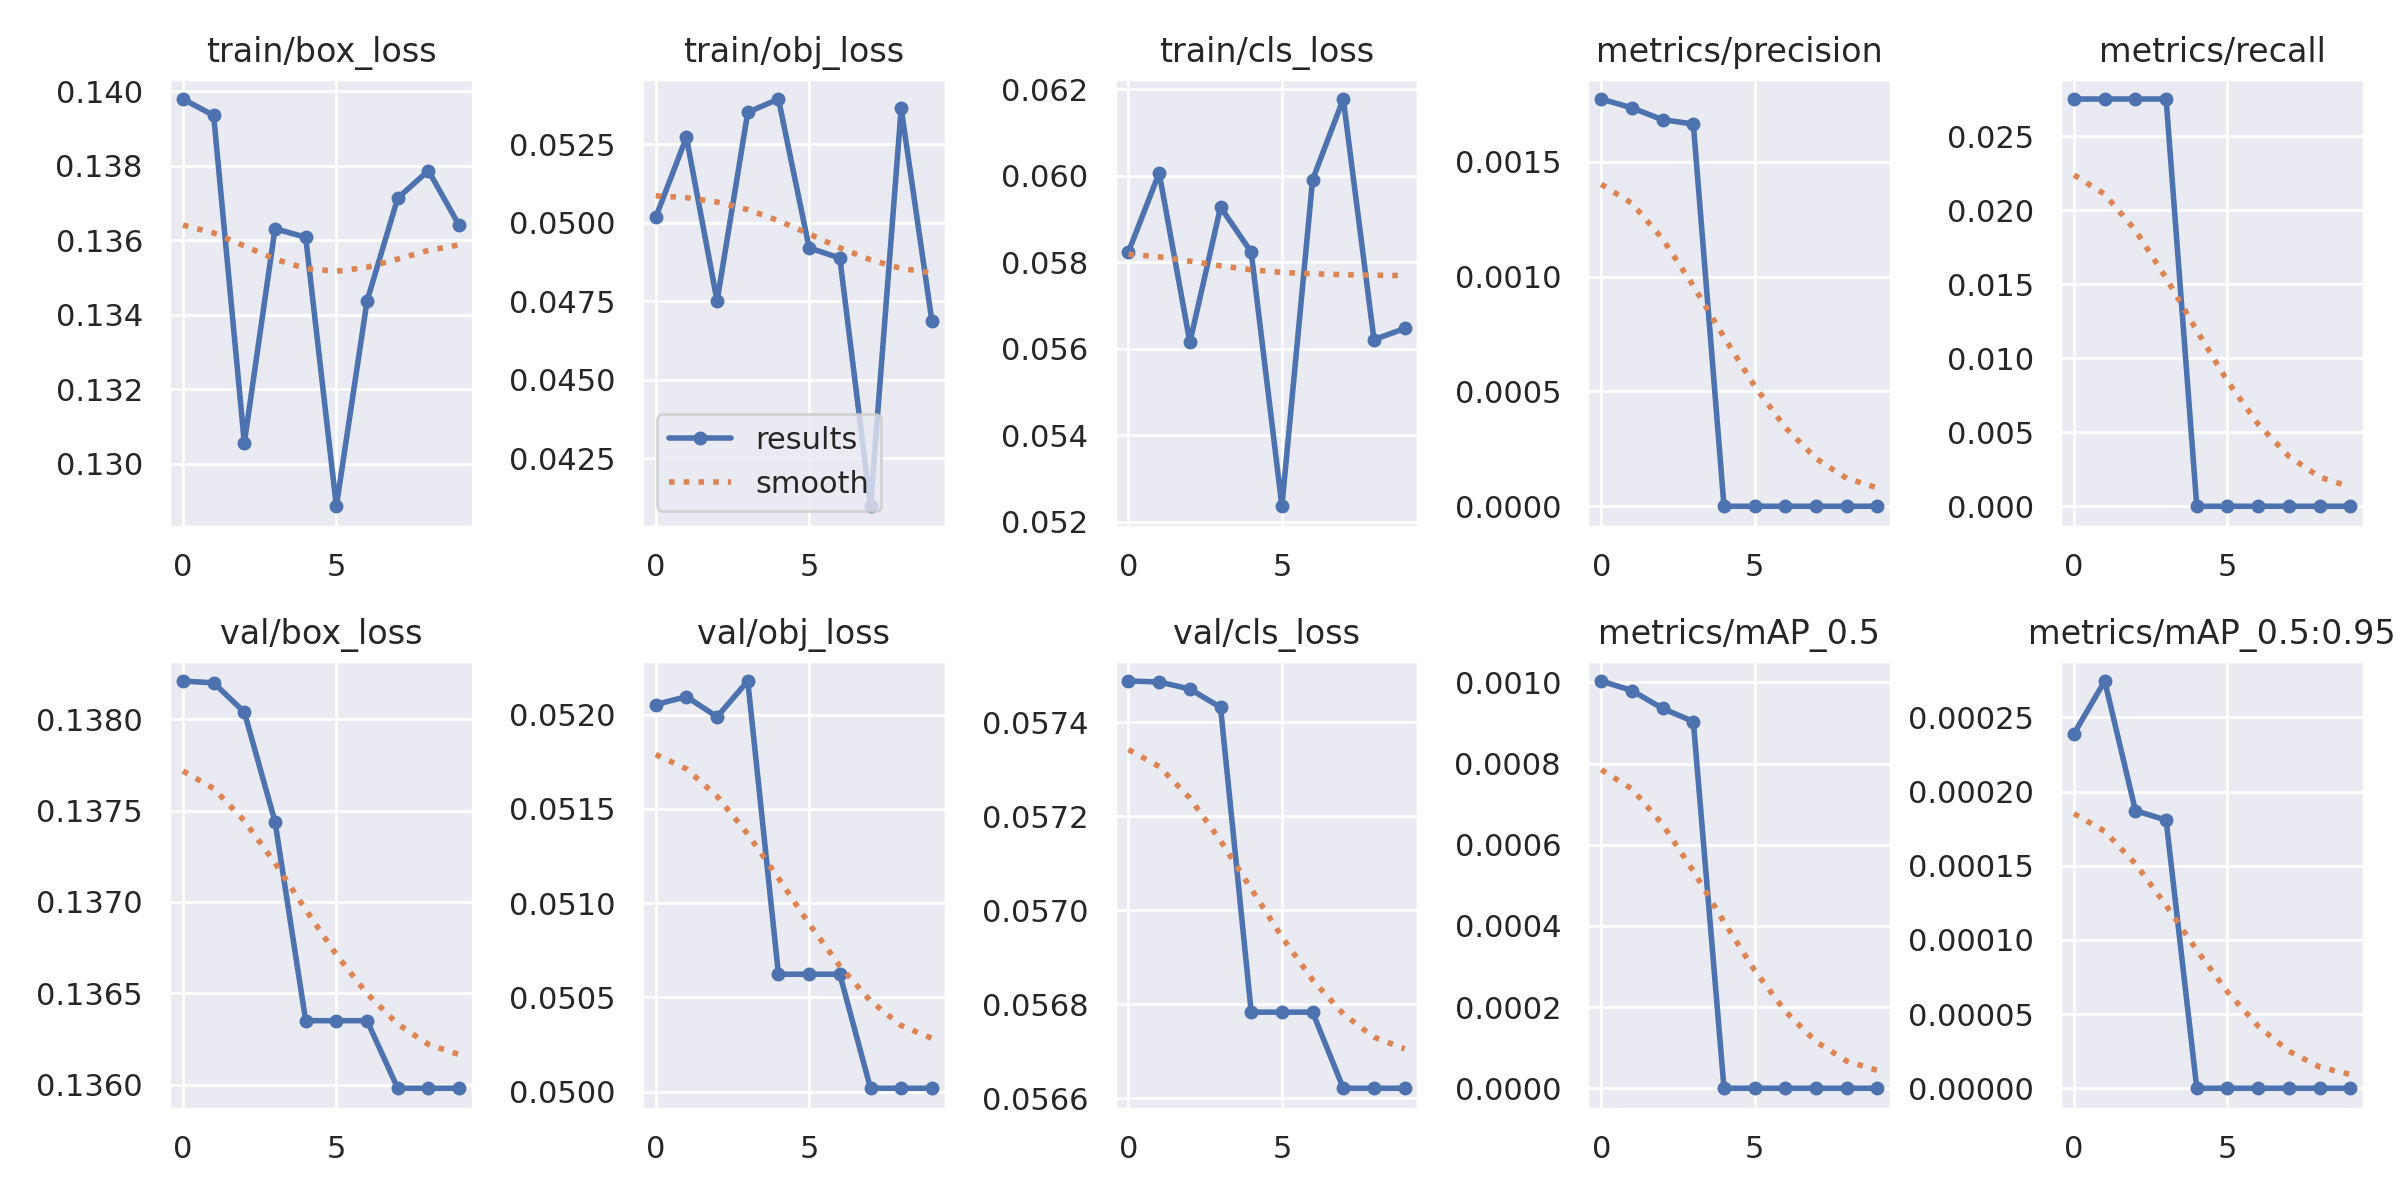


Weights: /root/driverless-ml-dev/yolov5/runs/train/fsoco_yolov5n21/weights/best.pt


In [72]:
from IPython.display import Image as IPImage

# Find latest run
runs = sorted((YOLO_DIR / 'runs' / 'train').glob('fsoco_*'), key=lambda x: x.stat().st_mtime)
if runs:
    latest = runs[-1]
    print(f"Training run: {latest.name}\n")
    
    # Show results
    results_img = latest / 'results.png'
    if results_img.exists():
        display(IPImage(filename=str(results_img)))
    
    print(f"\nWeights: {latest / 'weights' / 'best.pt'}")
else:
    print("No training runs found")

## 7. Run Inference

Running inference...

detect: weights=['/root/driverless-ml-dev/yolov5/runs/train/fsoco_yolov5n21/weights/best.pt'], source=/root/driverless-ml-dev/ml_data/perceptions/fsoco_yolo/images/test, data=../../../yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=100, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=../../../yolov5/runs/detect, name=fsoco_inference, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2025-10-4 Python-3.12.3 torch-2.8.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 1765930 parameters, 0 gradients, 4.1 GFLOPs
image 1/9 /root/driverless-ml-dev/ml_data/perceptions/fsoco_yolo/images/test/amz_00016.jpg: 512x640 (no detections), 25.9ms
image 2/9 /root/driverless-ml-dev/ml_data/perceptions/fsoco_yolo/images/

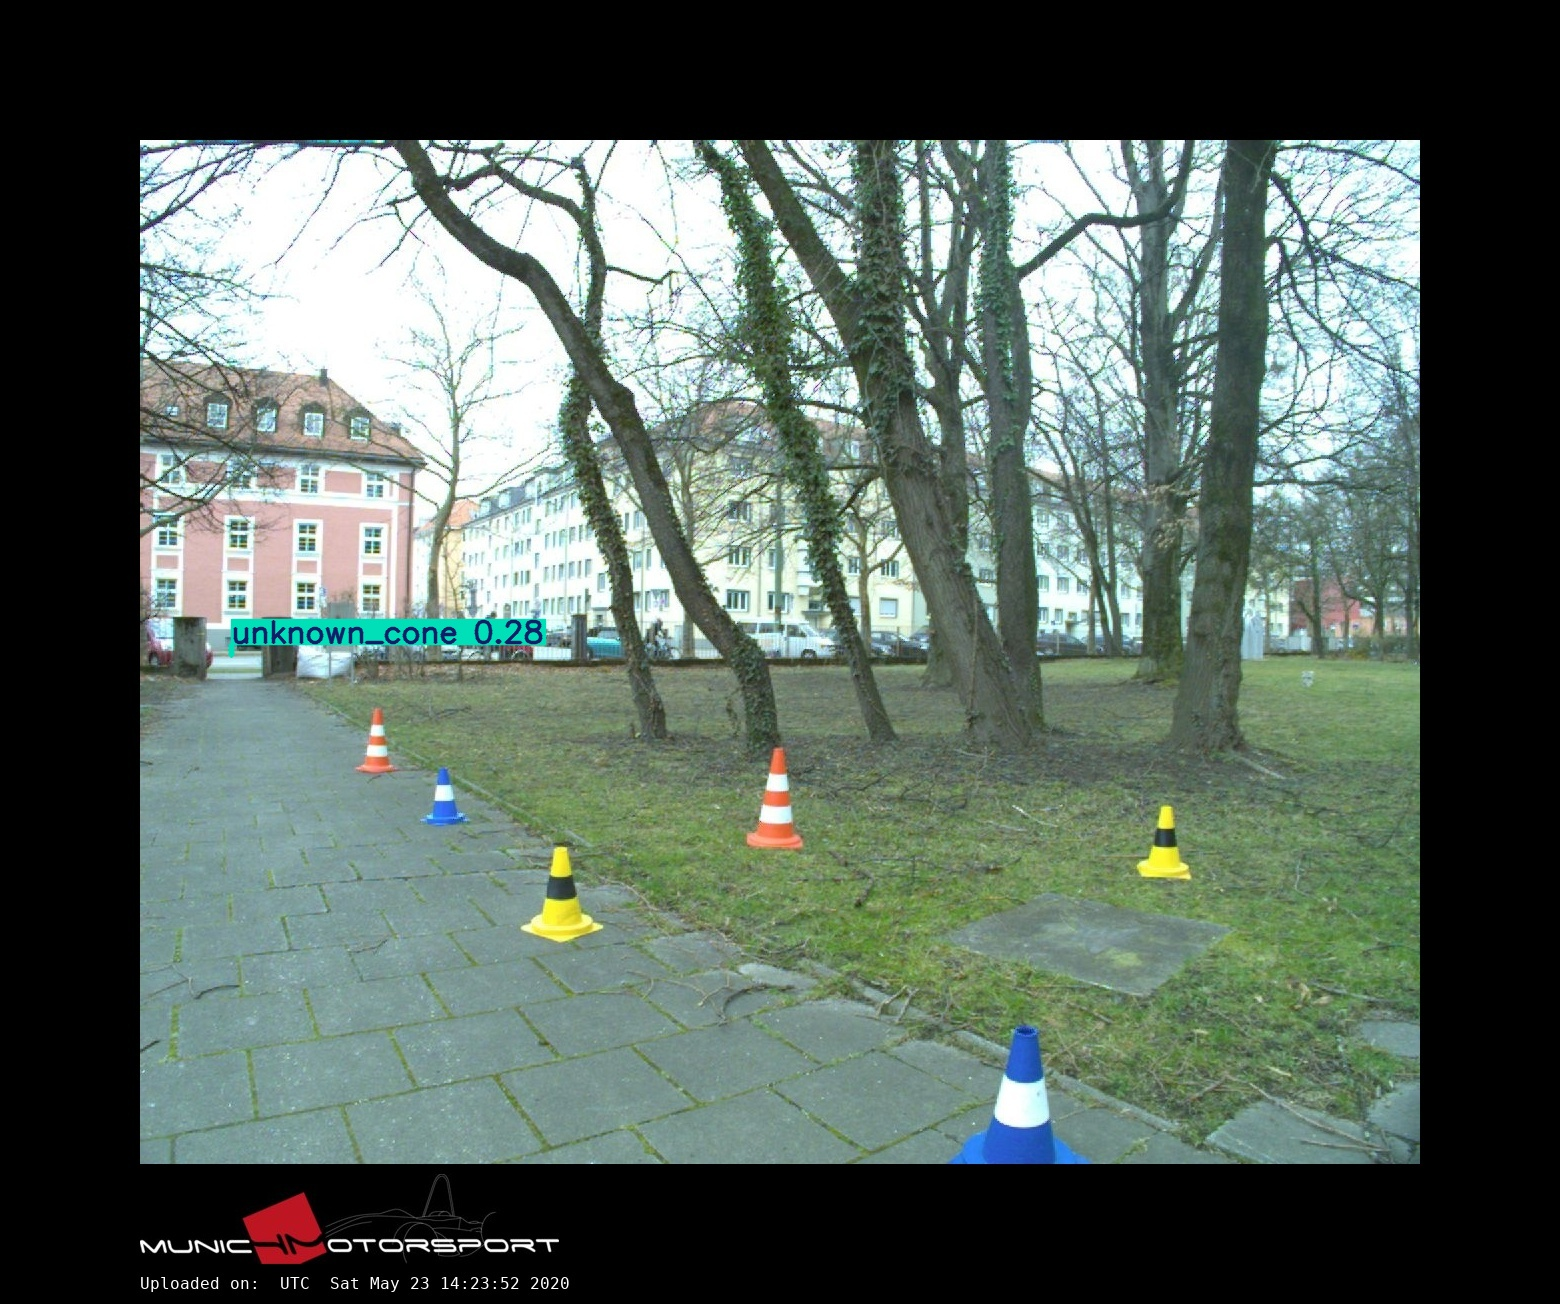

In [73]:
# Get trained weights
if runs:
    weights = runs[-1] / 'weights' / 'best.pt'
    test_imgs = FSOCO_YOLO / 'images' / 'test'
    
    if weights.exists() and test_imgs.exists():
        print("Running inference...\n")
        
        !python {YOLO_DIR}/detect.py \
            --weights {weights} \
            --source {test_imgs} \
            --img {IMG_SIZE} \
            --conf 0.25 \
            --name fsoco_inference \
            --max-det 100
        
        # Show results
        detect_runs = sorted((YOLO_DIR / 'runs' / 'detect').glob('fsoco_inference*'), 
                           key=lambda x: x.stat().st_mtime)
        if detect_runs:
            print(f"\nResults saved to: {detect_runs[-1]}")
            
            # Display first result
            results = list(detect_runs[-1].glob('*.jpg'))[:1]
            for r in results:
                display(IPImage(filename=str(r), width=800))
    else:
        print("Missing weights or test images")
else:
    print("Train model first")

In [ ]:
# Running YOLOv5 repo's benchmarks.py (PyTorch-only) ====
from pathlib import Path
import sys, pandas as pd, torch

# Paths/config
YOLO_DIR   = Path(globals().get("YOLO_DIR", "/root/driverless-ml-dev/yolov5"))
RUNS_TRAIN = YOLO_DIR / "runs" / "train"
RUNS_BENCH = YOLO_DIR / "runs" / "bench"; RUNS_BENCH.mkdir(parents=True, exist_ok=True)
DATA_YAML  = Path(globals().get("config_path", "/root/driverless-ml-dev/ml_data/perceptions/fsoco_yolo/fsoco.yaml"))
IMG        = int(globals().get("IMG_SIZE", 640))
DEVICE     = "0" if torch.cuda.is_available() else "cpu"

# Resolve newest trained weights (fsoco_* run)
candidates = sorted(RUNS_TRAIN.glob("fsoco_*/weights/best.pt"), key=lambda p: p.stat().st_mtime)
assert candidates, "No trained weights under yolov5/runs/train/fsoco_*/weights/best.pt"
W = candidates[-1]
print(f"Using weights: {W}\nData: {DATA_YAML}\nimg: {IMG}  device: {DEVICE}")

# Import YOLOv5 repo's benchmarks.py
sys.path.insert(0, str(YOLO_DIR))
try:
    import benchmarks as y5_bench        # repo root
except Exception:
    import utils.benchmarks as y5_bench  # older layout

# --- Patch CLI-only functions so argparse doesn't see Jupyter's --f flag
if hasattr(y5_bench, "parse_opt"):
    y5_bench.parse_opt = lambda: None
if hasattr(y5_bench, "notebook_init"):
    y5_bench.notebook_init = lambda *a, **k: None

# Run benchmark (PyTorch row only: Format, Size (MB), mAP50-95, Inference time (ms))
df = y5_bench.run(
    weights=W,
    imgsz=IMG,
    batch_size=1,
    data=DATA_YAML,
    device=DEVICE,
    half=False,
    test=False,
    pt_only=True,
    hard_fail=False
)

# Show and save
display(df)
out_csv = RUNS_BENCH / "y5_single_model_benchmark.csv"
df.assign(weights=str(W), img=IMG, device=DEVICE).to_csv(out_csv, index=False)
print("Saved:", out_csv)

# # === YOLOv5 Benchmarks: PyTorch + ONNX ===
# from pathlib import Path
# import sys, pandas as pd, torch

# # --- Paths & config -----------------------------------------------------------
# YOLO_DIR   = Path(globals().get("YOLO_DIR", "/root/driverless-ml-dev/yolov5"))
# RUNS_TRAIN = YOLO_DIR / "runs" / "train"
# RUNS_BENCH = YOLO_DIR / "runs" / "bench"; RUNS_BENCH.mkdir(parents=True, exist_ok=True)
# DATA_YAML  = Path(globals().get("config_path", "/root/driverless-ml-dev/ml_data/perceptions/fsoco_yolo/fsoco.yaml"))
# IMG        = int(globals().get("IMG_SIZE", 640))
# DEVICE     = "0" if torch.cuda.is_available() else "cpu"

# # --- Find newest trained weights ---------------------------------------------
# candidates = sorted(RUNS_TRAIN.glob("fsoco_*/weights/best.pt"), key=lambda p: p.stat().st_mtime)
# assert candidates, "No trained weights under yolov5/runs/train/fsoco_*/weights/best.pt"
# W = candidates[-1]
# print(f"Using weights: {W}\nData: {DATA_YAML}\nimg: {IMG}  device: {DEVICE}")

# # --- Import YOLOv5 benchmark module ------------------------------------------
# sys.path.insert(0, str(YOLO_DIR))
# try:
#     import benchmarks as y5_bench
# except Exception:
#     import utils.benchmarks as y5_bench  # older layout

# # Disable CLI parsing for notebooks
# if hasattr(y5_bench, "parse_opt"):
#     y5_bench.parse_opt = lambda: None
# if hasattr(y5_bench, "notebook_init"):
#     y5_bench.notebook_init = lambda *a, **k: None

# # --- 1️⃣ Run PyTorch benchmark -----------------------------------------------
# df_pt = y5_bench.run(
#     weights=W,
#     imgsz=IMG,
#     batch_size=1,
#     data=DATA_YAML,
#     device=DEVICE,
#     half=False,
#     test=False,
#     pt_only=True,     # Only PyTorch here
#     hard_fail=False
# )
# display(df_pt)

# # --- 2️⃣ Export to ONNX (opset 11) ------------------------------------------
# import export as y5_export
# onnx_path = y5_export.run(weights=W, imgsz=[IMG], include=['onnx'], opset=11)[-1]
# print(f"Exported ONNX to: {onnx_path}")

# # --- 3️⃣ Run ONNX benchmark --------------------------------------------------
# df_onnx = y5_bench.run(
#     weights=onnx_path,
#     imgsz=IMG,
#     batch_size=1,
#     data=DATA_YAML,
#     device=DEVICE,
#     half=False,
#     test=False,
#     pt_only=False,     # include ONNX and others if available
#     hard_fail=False
# )
# display(df_onnx)

# # --- 4️⃣ Save both results ---------------------------------------------------
# out_csv = RUNS_BENCH / "y5_pt_onnx_benchmark.csv"
# combined = pd.concat([df_pt.assign(format="PyTorch"), df_onnx.assign(format="ONNX")], ignore_index=True)
# combined.assign(weights=str(W), img=IMG, device=DEVICE).to_csv(out_csv, index=False)
# print("\n✅ Saved combined benchmark results to:", out_csv)


YOLOv5 🚀 2025-10-4 Python-3.12.3 torch-2.8.0+cpu CPU

YOLOv5 🚀 2025-10-4 Python-3.12.3 torch-2.8.0+cpu CPU



Using weights: /root/driverless-ml-dev/yolov5/runs/train/fsoco_yolov5n21/weights/best.pt
Data: /root/driverless-ml-dev/ml_data/perceptions/fsoco_yolo/fsoco.yaml
img: 640  device: cpu


Fusing layers... 
Model summary: 157 layers, 1765930 parameters, 0 gradients, 4.1 GFLOPs
val: Scanning /root/driverless-ml-dev/ml_data/perceptions/fsoco_yolo/labels/val.cache... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<?, ?it/s]
val: WARNING ⚠️ /root/driverless-ml-dev/ml_data/perceptions/fsoco_yolo/images/val/mms_00597.jpg: 2 duplicate labels removed
                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/8 [00:00<?, ?it/s]WARNING ⚠️ NMS time limit 0.550s exceeded
                 Class     Images  Instances          P          R      mAP50   mAP50-95:  12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]WARNING ⚠️ NMS time limit 0.550s exceeded
                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]WARNING ⚠️ NMS time limit 0.550s exceeded
                 Class     Images  Instances          P          R      mAP50   mAP50-95:  38%|███▊  

,Format,Size (MB),mAP50-95,Inference time (ms)
0,PyTorch,3.7,0.0001,57.91


YOLOv5 🚀 2025-10-4 Python-3.12.3 torch-2.8.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 1765930 parameters, 0 gradients, 4.1 GFLOPs

PyTorch: starting from /root/driverless-ml-dev/yolov5/runs/train/fsoco_yolov5n21/weights/best.pt with output shape (1, 25200, 10) (3.7 MB)

ONNX: starting export with onnx 1.19.0...
ONNX: export success ✅ 0.3s, saved as /root/driverless-ml-dev/yolov5/runs/train/fsoco_yolov5n21/weights/best.onnx (7.2 MB)

Export complete (0.4s)
Results saved to /root/driverless-ml-dev/yolov5/runs/train/fsoco_yolov5n21/weights
Detect:          python detect.py --weights /root/driverless-ml-dev/yolov5/runs/train/fsoco_yolov5n21/weights/best.onnx 
Validate:        python val.py --weights /root/driverless-ml-dev/yolov5/runs/train/fsoco_yolov5n21/weights/best.onnx 
PyTorch Hub:     model = torch.hub.load('ultralytics/yolov5', 'custom', '/root/driverless-ml-dev/yolov5/runs/train/fsoco_yolov5n21/weights/best.onnx')  
Visualize:       https://netron.app
YOLOv5 🚀 2025-10

Exported ONNX to: /root/driverless-ml-dev/yolov5/runs/train/fsoco_yolov5n21/weights/best.onnx


UnpicklingError: invalid load key, '\x08'.

## Done!

**Your model is trained and ready to use.**

**Quick commands:**
```bash
# Inference on images
python yolov5/detect.py --weights runs/train/fsoco_yolov5s/weights/best.pt --source /path/to/images

# Inference on video
python yolov5/detect.py --weights runs/train/fsoco_yolov5s/weights/best.pt --source video.mp4

# Inference on webcam
python yolov5/detect.py --weights runs/train/fsoco_yolov5s/weights/best.pt --source 0
```